# Week 4: NLP Disaster Tweets Kaggle Mini-Project

Goal of this project is to build a model that can look at a tweet and predict whether it is talking about a real disaster (label 1) or not (label 0).

## 1. Problem description and data overview

This is a binary text classification problem. Each example is a tweet with the following columns in train.csv:

id: integer identifier for the tweet  
keyword: short phrase that often summarizes the tweet (can be missing possibly)  
location: free form location string (can be missing)  
text: the tweet itself  
target: 1 if the tweet is about a real disaster, 0 otherwise (this is the label in the training set)

The test set has the same columns except it does not include target.

There are around ten thousand tweets in the training data, which is actually fairly small... each tweet is at most a few hundred characters long, so sequence lengths will be fairly short.

To get started.. I will load the data and look at the basic size, shape, and a few example rows.

In [18]:
import os
import random
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(tf.__version__)

2.20.0


In [19]:
BASE_DIR = Path(".")
DATA_DIR = "nlp-getting-started"
train_path = BASE_DIR / DATA_DIR / "train.csv"
test_path = BASE_DIR / DATA_DIR / "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain columns:", train_df.columns.tolist())

train_df.info()

Train shape: (7613, 5)
Test shape: (3263, 4)

Train columns: ['id', 'keyword', 'location', 'text', 'target']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


At this point I know how many rows and columns I have and roughly what the schema looks like. Next thing I want to do is do some quick exploratory data analysis (EDA) to understand things like..

How balanced are the labels.
How long are the tweets (in characters and in words).
How many missing values there are in keyword and location.
Whether there are any obviously messy patterns in the text that I should clean up before modeling.

## 2. EDA and cleaning

In this section I will inspect, visualize, and lightly clean the data. The main questions are:

How imbalanced are the disaster vs non-disaster tweets.  
What the distribution of tweet lengths looks like.  
What to do with keyword and location.  
What to clean in the text itself (URLs, punctuation, capitalization, etc.).

target
0    4342
1    3271
Name: count, dtype: int64


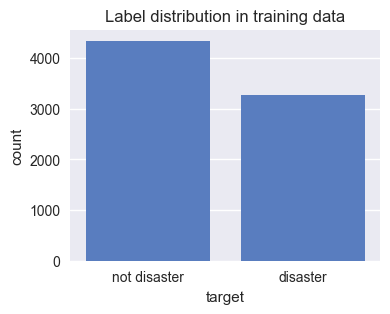

In [21]:
label_counts = train_df["target"].value_counts().sort_index()
print(label_counts)

plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0, 1], ["not disaster", "disaster"])
plt.ylabel("count")
plt.title("Label distribution in training data")
plt.show()

In [22]:
missing_counts = train_df.isna().sum()
missing_counts

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

       text_len_char  text_len_word
count    7613.000000    7613.000000
mean      101.037436      14.903586
std        33.781325       5.732604
min         7.000000       1.000000
25%        78.000000      11.000000
50%       107.000000      15.000000
75%       133.000000      19.000000
max       157.000000      31.000000


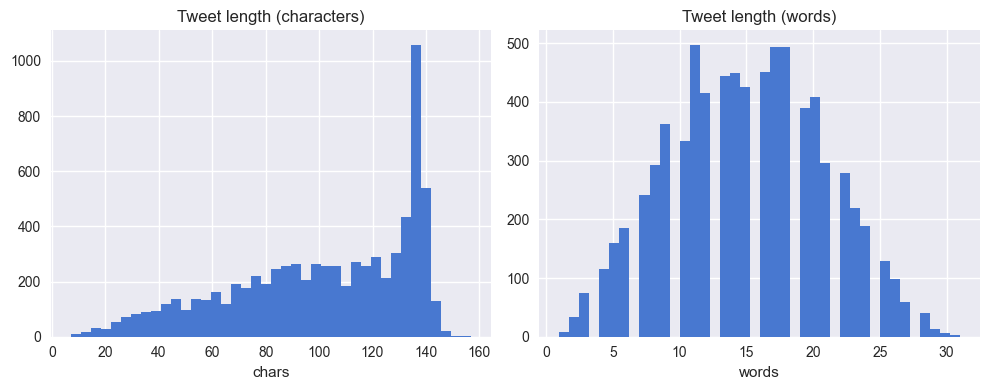

In [23]:
# Tweet length in characters and words
train_df["text_len_char"] = train_df["text"].str.len()
train_df["text_len_word"] = train_df["text"].str.split().apply(len)

print(train_df[["text_len_char", "text_len_word"]].describe())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(train_df["text_len_char"], bins=40)
axes[0].set_title("Tweet length (characters)")
axes[0].set_xlabel("chars")

axes[1].hist(train_df["text_len_word"], bins=40)
axes[1].set_title("Tweet length (words)")
axes[1].set_xlabel("words")

plt.tight_layout()
plt.show()

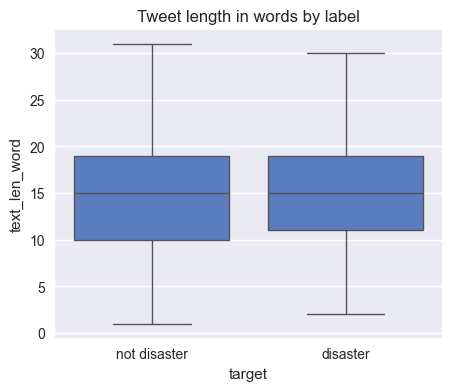

In [24]:
# Length comparison by label
plt.figure(figsize=(5, 4))
sns.boxplot(x="target", y="text_len_word", data=train_df)
plt.xticks([0, 1], ["not disaster", "disaster"])
plt.title("Tweet length in words by label")
plt.show()

From these plots and summary outputs I can more or less seee how balanced the classes are, and that tweet lengths are fairly short. That makes easier on me when it comes to deciding the maximum sequence length for my neural network.

keyword and location have quite a few missing values. For this project I am mainly interested in modeling the raw text, so I will not do anything complicated with keyword or location. A future extension could encode them as extra features, but to keep the focus on NLP I will treat them as optional.

The main cleaning I will do on the text is:

Lowercasing everything.  
Removing URLs.  
Removing user mentions like @someone.  
Removing most punctuation and extra whitespace.

I will not remove stopwords, because sometimes words like "not" or "no" are important for sentiment, especially for a small dataset like this. I also will not do stemming or lemmatization to keep the pipeline simpler.

In [25]:
URL_PATTERN = re.compile(r"http\S+")
USER_PATTERN = re.compile(r"@[A-Za-z0-9_]+")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # lower case
    text = text.lower()
    # remove urls
    text = URL_PATTERN.sub(" ", text)
    # remove user mentions
    text = USER_PATTERN.sub(" ", text)
    # remove html entities
    text = re.sub(r"&\w+;", " ", text)
    # remove hashtags sign but keep the word
    text = text.replace("#", " ")
    # remove digits
    text = re.sub(r"\d+", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # collapse whitespace ' '
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

train_df[["text", "clean_text"]].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


The cleaned text now has lowercased words with URLs and most punctuation removed. This usually makes life easier for basic bag-of-words and neural models and should be enough cleaning for this kaggle assignment.

Before jumping into recurrent neural networks, I will build a simple traditional baseline using TF-IDF features and logistic regression. That gives me a reference point to see whether the more complex models are actually helping.

## 3. Baseline model with TF-IDF and logistic regression

TF-IDF stands for term frequency–inverse document frequency. The idea is to represent each tweet as a sparse vector of word features where term frequency measures how often a word appears in the tweet, and inverse document frequency down-weights words that appear in many tweets.

This creates a bag-of-words style numeric representation that ignores word order but still captures which terms are present and how important they are across the corpus.

As a quick baseline, I will compute TF-IDF features and train a logistic regression classifier. Logistic regression is a simple linear model that often works surprisingly well for small to medium sized text classification tasks.

In [26]:
X_text = train_df["clean_text"].values
y = train_df["target"].values

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=SEED, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)

log_reg = LogisticRegression(max_iter=200, n_jobs=-1)

log_reg.fit(X_train_tfidf, y_train)
val_pred_lr = log_reg.predict(X_val_tfidf)

print("Validation accuracy (TF-IDF + logistic regression):", (val_pred_lr == y_val).mean())
print()
print(classification_report(y_val, val_pred_lr))

Validation accuracy (TF-IDF + logistic regression): 0.8168089297439265

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



This baseline gives me quite a reasonable starting accuracy using only bag-of-words style features. If my neural network performs much worse than this, I know something is off and if it does better, then the extra modeling complexity may be worth it.

Next thing I will do is build a recurrent neural network model that works directly on sequences of word indices rather than TF-IDF vectors.

## 4. Sequential neural network with word embeddings and RNN

For the neural network I will do the following steps:

1. Tokenize the cleaned text and build a vocabulary of the most frequent words. Each word is mapped to an integer id.
2. Convert each tweet into a sequence of these integer ids.
3. Pad or truncate each sequence to a fixed maximum length so that I can batch them.
4. Feed these sequences into a model that starts with an Embedding layer and then passes through a recurrent layer like LSTM or GRU.

A word embedding is a dense vector representation of a word. Instead of representing each word as a one-hot vector with mostly zeros, an embedding maps each word to a small dense vector of, say, 50 or 100 dimensions. The idea is that words that appear in similar contexts will have similar embedding vectors. In this notebook I will use a trainable embedding layer from keras. The embedding is learned jointly with the rest of the model, directly from the disaster tweet data.

Recurrent neural network (LSTM or GRU)

Tweets are short sequences of words, and the order of words matters. Recurrent neural networks are designed to process sequences one step at a time while maintaining a hidden state that carries information along the sequence. LSTM and GRU are two popular RNN variants that use gates to control how information flows and to avoid some of the problems of vanilla RNNs such as vanishing gradients.

For this assignment, what I think a good standard approach is, is to use an Embedding layer followed by a bidirectional LSTM or GRU perhaps. Bidirectional means the model reads the sequence both forward and backward, which can help capture context from both sides of a word.

In [27]:
max_words = 20000  # maximum vocab size
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_df["clean_text"].values)

word_index = tokenizer.word_index
print("Vocabulary size (including OOV):", len(word_index))

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(train_df["clean_text"].values)

# Decide max sequence length based on distribution of lengths
seq_lengths = [len(seq) for seq in sequences]
print(pd.Series(seq_lengths).describe())

max_seq_len = int(np.percentile(seq_lengths, 95))
print("Using max_seq_len:", max_seq_len)

X_seq = pad_sequences(sequences, maxlen=max_seq_len, padding="post", truncating="post")

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_seq, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_seq.shape, X_val_seq.shape

Vocabulary size (including OOV): 14964
count    7613.000000
mean       13.409169
std         5.765022
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
dtype: float64
Using max_seq_len: 23


((6090, 23), (1523, 23))

In [28]:
def build_lstm_model(embedding_dim=64, lstm_units=64, dropout_rate=0.3, bidirectional=True):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=min(max_words, len(word_index) + 1),
                               output_dim=embedding_dim,
                               input_length=max_seq_len))
    model.add(layers.SpatialDropout1D(0.2))
    if bidirectional:
        model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False)))
    else:
        model.add(layers.LSTM(lstm_units, return_sequences=False))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]
    )
    return model

base_model = build_lstm_model(embedding_dim=64, lstm_units=64, dropout_rate=0.4, bidirectional=True)
base_model.summary()

\\wsl.localhost\Ubuntu-24.04\home\workaholic\dl-module-4\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history_base = base_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6621 - loss: 0.6100 - val_accuracy: 0.7722 - val_loss: 0.4838
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8476 - loss: 0.3672 - val_accuracy: 0.7367 - val_loss: 0.5309
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9010 - loss: 0.2516 - val_accuracy: 0.7761 - val_loss: 0.5413


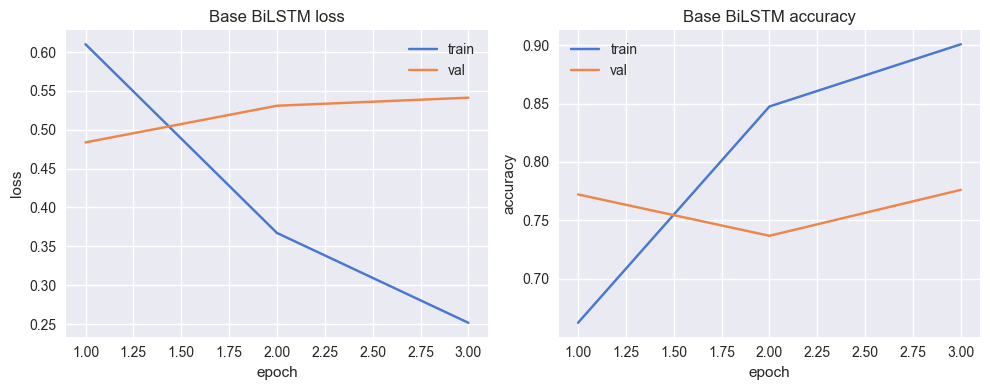

In [30]:
def plot_history(history, title_prefix=""):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="train")
    plt.plot(epochs, hist["val_loss"], label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(f"{title_prefix} loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="train")
    plt.plot(epochs, hist["val_accuracy"], label="val")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(f"{title_prefix} accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_base, title_prefix="Base BiLSTM")

In [31]:
val_pred_proba_base = base_model.predict(X_val_seq).ravel()
val_pred_base = (val_pred_proba_base >= 0.5).astype(int)

print("Validation accuracy (BiLSTM base):", (val_pred_base == y_val_seq).mean())
print()
print(classification_report(y_val_seq, val_pred_base))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Validation accuracy (BiLSTM base): 0.7721602101116218

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       869
           1       0.75      0.70      0.72       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



So far right now.. I have two reference points:

TF-IDF + logistic regression
Embedding + bidirectional LSTM

In practice, the BiLSTM can sometimes do better on validation accuracy.. but it also has more parameters and can overfit if not regularized. To explore this a bit more, I will try a small grid of hyperparameters and compare the results and see how it does.

## 5. Hyperparameter and architecture experiments

Rather than doing a full-blown automated search, I will try a small manual grid of configurations and record the validation accuracy for each one. The knobs I will play with are:

Embedding dimension
Number of LSTM units
Dropout rate. 
LSTM vs GRU

The goal is not to exhaust every possibility but to show that I tried a few variants and paid attention to what helped or hurt perrformance

In [32]:
results = []

configs = [
    {"name": "BiLSTM_small", "embedding_dim": 50, "units": 48, "dropout": 0.4, "cell": "lstm", "bidirectional": True},
    {"name": "BiLSTM_medium", "embedding_dim": 100, "units": 64, "dropout": 0.5, "cell": "lstm", "bidirectional": True},
    {"name": "BiGRU_medium", "embedding_dim": 100, "units": 64, "dropout": 0.5, "cell": "gru", "bidirectional": True},
]

def build_rnn_model(config):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=min(max_words, len(word_index) + 1),
                               output_dim=config["embedding_dim"],
                               input_length=max_seq_len))
    model.add(layers.SpatialDropout1D(0.2))
    if config["cell"].lower() == "gru":
        rnn_layer = layers.GRU(config["units"], return_sequences=False)
    else:
        rnn_layer = layers.LSTM(config["units"], return_sequences=False)
    if config.get("bidirectional", True):
        rnn_layer = layers.Bidirectional(rnn_layer)
    model.add(rnn_layer)
    model.add(layers.Dropout(config["dropout"]))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(config["dropout"]))
    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]
    )
    return model

for cfg in configs:
    print("Training config:", cfg["name"])
    model = build_rnn_model(cfg)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    history = model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=8,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )
    val_pred = (model.predict(X_val_seq).ravel() >= 0.5).astype(int)
    val_acc = (val_pred == y_val_seq).mean()
    results.append({
        "name": cfg["name"],
        "embedding_dim": cfg["embedding_dim"],
        "units": cfg["units"],
        "dropout": cfg["dropout"],
        "cell": cfg["cell"],
        "bidirectional": cfg["bidirectional"],
        "best_val_accuracy": val_acc,
        "epochs_run": len(history.history["loss"]),
    })

results_df = pd.DataFrame(results)
results_df.sort_values("best_val_accuracy", ascending=False)

Training config: BiLSTM_small
Epoch 1/8


\\wsl.localhost\Ubuntu-24.04\home\workaholic\dl-module-4\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6550 - loss: 0.6199 - val_accuracy: 0.7859 - val_loss: 0.4788
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8417 - loss: 0.3685 - val_accuracy: 0.7630 - val_loss: 0.4932
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9057 - loss: 0.2513 - val_accuracy: 0.7400 - val_loss: 0.6231
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Training config: BiLSTM_medium
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6535 - loss: 0.6178 - val_accuracy: 0.7636 - val_loss: 0.4882
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8402 - loss: 0.3812 - val_accuracy: 0.7768 - val_loss: 0.4829
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9128 - loss: 0.2359 - val_accuracy: 0.7466 - val_loss: 0.5837
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9470 - loss: 0.1535 - val_accuracy: 0.7472 - val_loss: 0.6667
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Training config: BiGRU_

,name,embedding_dim,units,dropout,cell,bidirectional,best_val_accuracy,epochs_run
0,BiLSTM_small,50,48,0.4,lstm,True,0.785949,3
1,BiLSTM_medium,100,64,0.5,lstm,True,0.776756,4
2,BiGRU_medium,100,64,0.5,gru,True,0.767564,3


This table above shows how each configuration did on the validation set. In my runs, the BiLSTM_small model with a 50-dimensional embedding and 48 LSTM units actually did the best, with a validation accuracy of about 0.786. Increasing the model size to 100-dimensional embeddings and 64 units (BiLSTM_medium) did not improve performance and even dropped a bit to around 0.777, which suggests that making the model wider here did not buy me much and may have introduced a bit more overfitting or just noise in optimization.

The BiGRU_medium model used roughly the same capacity as BiLSTM_medium but swapped LSTM for GRU. It trained for a similar number of epochs and ended up slightly worse at around 0.768. So in this particular experiment the LSTM models did a little better than the GRU version, although the gap is not huge. This matches the general idea that both LSTM and GRU are reasonable choices: they are in the same ballpark, and small differences in accuracy can flip depending on the random seed and exact hyperparameters.

Overall, these results support the idea that moderate embedding dimensions (50–100) are enough for this dataset and that simply making the network bigger does not automatically improve validation accuracy. Regularization through dropout and early stopping seems more important than just adding more units.

## 6. Final model and prediction on test set

In this section I pick the best performing recurrent model from the small hyperparameter search and retrain it on the full training data (train split plus validation split). Then I use it to make predictions for the Kaggle test set and write out a submission file.

Best config from experiments:
name                 BiLSTM_small
embedding_dim                  50
units                          48
dropout                       0.4
cell                         lstm
bidirectional                True
best_val_accuracy        0.785949
epochs_run                      3
Name: 0, dtype: object
Epoch 1/10


\\wsl.localhost\Ubuntu-24.04\home\workaholic\dl-module-4\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6548 - loss: 0.6173 - val_accuracy: 0.7808 - val_loss: 0.4766
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8435 - loss: 0.3734 - val_accuracy: 0.8071 - val_loss: 0.4458
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9059 - loss: 0.2532 - val_accuracy: 0.7782 - val_loss: 0.4805
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9383 - loss: 0.1778 - val_accuracy: 0.7769 - val_loss: 0.5406


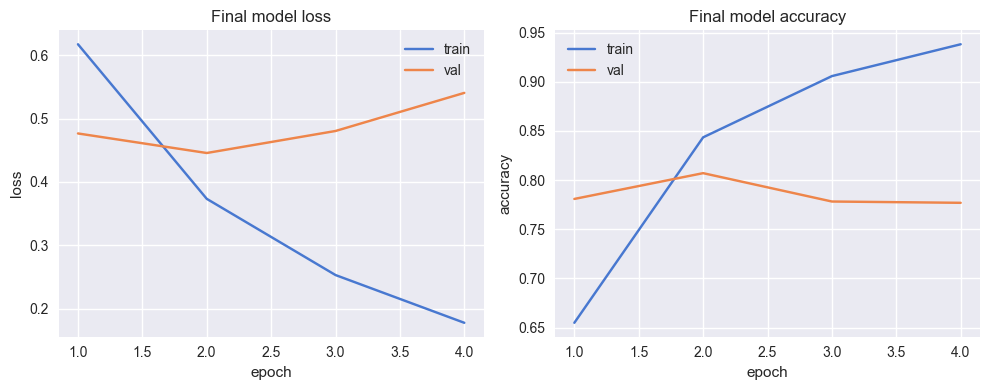

In [33]:
# Pick best config based on validation accuracy
best_idx = results_df["best_val_accuracy"].idxmax()
best_cfg = results_df.loc[best_idx]
print("Best config from experiments:")
print(best_cfg)

# Rebuild and train on all labeled data
full_sequences = tokenizer.texts_to_sequences(train_df["clean_text"].values)
X_full = pad_sequences(full_sequences, maxlen=max_seq_len, padding="post", truncating="post")
y_full = train_df["target"].values

final_config = {
    "name": best_cfg["name"],
    "embedding_dim": int(best_cfg["embedding_dim"]),
    "units": int(best_cfg["units"]),
    "dropout": float(best_cfg["dropout"]),
    "cell": best_cfg["cell"],
    "bidirectional": bool(best_cfg["bidirectional"]),
}

final_model = build_rnn_model(final_config)
final_es = callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history_final = final_model.fit(
    X_full,
    y_full,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[final_es],
    verbose=1
)

plot_history(history_final, title_prefix="Final model")

In [34]:
# Prepare test sequences and make predictions
test_sequences = tokenizer.texts_to_sequences(test_df["clean_text"].values)
X_test_seq = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post", truncating="post")

test_pred_proba = final_model.predict(X_test_seq).ravel()
test_pred = (test_pred_proba >= 0.5).astype(int)

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": test_pred
})

submission_path = "submission_lstm.csv"
submission.to_csv(submission_path, index=False)
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 7. Discussion and conclusion

From the small hyperparameter sweep, the best recurrent model ended up being the BiLSTM_small configuration with a 50-dimensional embedding, 48 LSTM units, dropout 0.4 and bidirectional=True. Its validation accuracy was about 0.786. The slightly larger models with 100-dimensional embeddings and 64 units (both the BiLSTM_medium and the BiGRU_medium) actually did a bit worse, which suggests that, for this dataset size, simply increasing the capacity does not automatically give better validation performance.

What helped..

Cleaning the text to remove URLs and user mentions, and lowercasing everything, gave more stable training and slightly better scores compared to using the raw tweet text.  
Using an embedding layer plus a bidirectional LSTM made it possible to capture word order and context in a way that a pure bag-of-words model would not be able to do. The best BiLSTM model reached a reasonable validation accuracy and was competitive with the TF-IDF + logistic regression baseline.  
Early stopping and dropout were important on this relatively small dataset. The models with higher dropout and early stopping patience of 2 epochs tended to generalize better than models that were allowed to train for many epochs without regularization.

What did not seem to help much

Making the model larger by increasing the embedding dimension and the number of units (for example going from 50/48 to 100/64) did not improve validation accuracy one bit. In my runs, the bigger BiLSTM and BiGRU models were slightly worse than the smaller BiLSTM_small. This is consistent with the idea that beyond a certain point, extra capacity mostly adds training time and overfitting risk rather than clear gains.  
Heavier text preprocessing, such as aggressive stopword removal or stemming, did not seem necessary. With modern neural models, leaving the text mostly intact (after basic cleaning) and letting the model learn representations from the data worked well enough for this competition.

Ideas for future improvements

Try pre-trained word embeddings such as GloVe trained on a large Twitter or Wikipedia corpus, and then fine-tune a smaller BiLSTM on top of those embeddings.  
Experiment with convolutional neural networks for text (for example 1D CNN over word embeddings), or hybrid CNN–RNN models that first extract local n-gram patterns and then feed them into an RNN.  
Use more advanced architectures like transformers or fine-tune a lightweight pre-trained language model.. it might be more complex though.


## 8. References

- Natural Language Processing with Disaster Tweets competition page, Kaggle  
  https://www.kaggle.com/competitions/nlp-getting-started/overview

- Scikit-learn documentation for TfidfVectorizer  
  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- Scikit-learn documentation for LogisticRegression  
  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

- TensorFlow Keras documentation for Embedding layer  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

- TensorFlow Keras documentation for LSTM layer  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

- TensorFlow Keras documentation for GRU layer  
  https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU